In [8]:
!pip install librosa numpy scikit-learn matplotlib tqdm
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# configuration
DATA_DIR = 'fma_small/' # Change this
SAVE_DIR = 'processed_data/'
SAMPLE_RATE = 22050  # Standard for many music models
DURATION_SEC = 5     # Length of each chunk
N_MELS = 128         # Height of the spectrogram (frequency bins)

# 🔧 NOUVEAU: Limitation du nombre de dossiers à traiter
MAX_FOLDERS = 50     # Traiter seulement les 50 premiers dossiers (au lieu de tous)
                     # Mettez None pour traiter tous les dossiers

print(f"📊 Configuration:")
print(f"   - Dossiers à traiter: {'Tous' if MAX_FOLDERS is None else MAX_FOLDERS}")
print(f"   - Durée par segment: {DURATION_SEC} secondes")
print(f"   - Sample rate: {SAMPLE_RATE} Hz")
print(f"   - Mel bins: {N_MELS}")

os.makedirs(SAVE_DIR, exist_ok=True)

📊 Configuration:
   - Dossiers à traiter: 50
   - Durée par segment: 5 secondes
   - Sample rate: 22050 Hz
   - Mel bins: 128
📊 Configuration:
   - Dossiers à traiter: 50
   - Durée par segment: 5 secondes
   - Sample rate: 22050 Hz
   - Mel bins: 128


In [9]:
def create_mel_spectrogram(audio_chunk, sr, n_mels=128):
    # Compute Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio_chunk, sr=sr, n_mels=n_mels)
    
    # Convert power to decibels (log scale) - crucial for diffusion models
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalize to [-1, 1] for the U-Net
    normalized_spec = (log_mel_spec + 40) / 40 # Adjust based on your DB range
    return normalized_spec

In [10]:
# 📊 Analyse du dataset avant traitement
print("🔍 Analyse du dataset FMA:")

total_folders = 0
total_mp3_files = 0

for root, dirs, files in os.walk(DATA_DIR):
    mp3_files = [f for f in files if f.endswith('.mp3')]
    if mp3_files:
        total_folders += 1
        total_mp3_files += len(mp3_files)
        
        if total_folders <= 5:  # Affiche les 5 premiers dossiers
            print(f"   📁 {os.path.basename(root)}: {len(mp3_files)} fichiers MP3")

print(f"\n📈 Statistiques totales:")
print(f"   - Dossiers avec MP3: {total_folders}")
print(f"   - Fichiers MP3 total: {total_mp3_files}")

if MAX_FOLDERS is not None and MAX_FOLDERS < total_folders:
    print(f"\n⚡ Traitement limité à {MAX_FOLDERS} dossiers sur {total_folders}")
    estimated_files = int((total_mp3_files / total_folders) * MAX_FOLDERS)
    print(f"   - Estimation fichiers traités: ~{estimated_files}")
else:
    print(f"\n🚀 Traitement complet de tous les {total_folders} dossiers")

🔍 Analyse du dataset FMA:
   📁 058: 36 fichiers MP3
   📁 009: 23 fichiers MP3
   📁 136: 30 fichiers MP3
   📁 103: 9 fichiers MP3
   📁 041: 25 fichiers MP3

📈 Statistiques totales:
   - Dossiers avec MP3: 156
   - Fichiers MP3 total: 8000

⚡ Traitement limité à 50 dossiers sur 156
   - Estimation fichiers traités: ~2564


In [11]:
all_spectrograms = []
folders_processed = 0

# Walk through directories avec limitation
for root, dirs, files in os.walk(DATA_DIR):
    # Vérification de la limitation de dossiers
    if MAX_FOLDERS is not None and folders_processed >= MAX_FOLDERS:
        print(f"🛑 Limite atteinte: {MAX_FOLDERS} dossiers traités")
        break
    
    # Traiter seulement si le dossier contient des fichiers MP3
    mp3_files = [f for f in files if f.endswith('.mp3')]
    if not mp3_files:
        continue
        
    print(f"📁 Traitement dossier {folders_processed + 1}: {os.path.basename(root)} ({len(mp3_files)} fichiers MP3)")
    folders_processed += 1
    
    for file in tqdm(mp3_files, desc=f"Dossier {folders_processed}", leave=False):
        file_path = os.path.join(root, file)
        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            # Calculate samples per chunk
            samples_per_chunk = DURATION_SEC * SAMPLE_RATE
            
            # Create chunks
            for i in range(0, len(y) - samples_per_chunk, samples_per_chunk):
                chunk = y[i : i + samples_per_chunk]
                spec = create_mel_spectrogram(chunk, SAMPLE_RATE, N_MELS)
                all_spectrograms.append(spec)
                
        except Exception as e:
            print(f"❌ Erreur traitement {file}: {e}")

# Convert list to a large numpy array [N, Channels, H, W]
# We add a channel dimension (1) so the U-Net treats it like a grayscale image
dataset = np.array(all_spectrograms)[:, np.newaxis, :, :]
print(f"✅ Total spectrogrammes créés: {dataset.shape}")
print(f"📁 Dossiers traités: {folders_processed}")
print(f"🎵 Segments de {DURATION_SEC}s: {len(all_spectrograms)}")

📁 Traitement dossier 1: 058 (36 fichiers MP3)


📁 Traitement dossier 2: 009 (23 fichiers MP3)


📁 Traitement dossier 3: 136 (30 fichiers MP3)


📁 Traitement dossier 4: 103 (9 fichiers MP3)


📁 Traitement dossier 5: 041 (25 fichiers MP3)


📁 Traitement dossier 6: 023 (19 fichiers MP3)


📁 Traitement dossier 7: 153 (6 fichiers MP3)


📁 Traitement dossier 8: 131 (94 fichiers MP3)


📁 Traitement dossier 9: 073 (87 fichiers MP3)


📁 Traitement dossier 10: 137 (62 fichiers MP3)


📁 Traitement dossier 11: 052 (76 fichiers MP3)


📁 Traitement dossier 12: 042 (55 fichiers MP3)


📁 Traitement dossier 13: 093 (35 fichiers MP3)


📁 Traitement dossier 14: 085 (84 fichiers MP3)


📁 Traitement dossier 15: 089 (35 fichiers MP3)


📁 Traitement dossier 16: 091 (79 fichiers MP3)


📁 Traitement dossier 17: 144 (65 fichiers MP3)


📁 Traitement dossier 18: 079 (17 fichiers MP3)


📁 Traitement dossier 19: 066 (36 fichiers MP3)


📁 Traitement dossier 20: 012 (67 fichiers MP3)


📁 Traitement dossier 21: 056 (76 fichiers MP3)


📁 Traitement dossier 22: 008 (10 fichiers MP3)


📁 Traitement dossier 23: 005 (17 fichiers MP3)


📁 Traitement dossier 24: 075 (98 fichiers MP3)


📁 Traitement dossier 25: 151 (1 fichiers MP3)


📁 Traitement dossier 26: 045 (42 fichiers MP3)


📁 Traitement dossier 27: 118 (64 fichiers MP3)


📁 Traitement dossier 28: 125 (85 fichiers MP3)


📁 Traitement dossier 29: 152 (15 fichiers MP3)


📁 Traitement dossier 30: 030 (26 fichiers MP3)


📁 Traitement dossier 31: 067 (57 fichiers MP3)


📁 Traitement dossier 32: 141 (65 fichiers MP3)


📁 Traitement dossier 33: 062 (56 fichiers MP3)


📁 Traitement dossier 34: 015 (20 fichiers MP3)


📁 Traitement dossier 35: 018 (22 fichiers MP3)


📁 Traitement dossier 36: 088 (31 fichiers MP3)


📁 Traitement dossier 37: 114 (128 fichiers MP3)


📁 Traitement dossier 38: 094 (33 fichiers MP3)


📁 Traitement dossier 39: 087 (61 fichiers MP3)


📁 Traitement dossier 40: 071 (68 fichiers MP3)


📁 Traitement dossier 41: 090 (30 fichiers MP3)


📁 Traitement dossier 42: 126 (160 fichiers MP3)


📁 Traitement dossier 43: 098 (82 fichiers MP3)


Dossier 43:  21%|██        | 17/82 [00:02<00:10,  6.47it/s]/tmp/ipykernel_33482/2717038218.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/home/msekkat/miniconda3/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_33482/2717038218.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
[src/libm

❌ Erreur traitement 098569.mp3: 


Dossier 43:  24%|██▍       | 20/82 [00:03<00:08,  7.14it/s]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Dossier 43:  27%|██▋       | 22/82 [00:03<00:06,  8.65it/s]

❌ Erreur traitement 098567.mp3: 


Dossier 43:  48%|████▊     | 39/82 [00:05<00:05,  7.25it/s]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Dossier 43:  50%|█████     | 41/82 [00:06<00:04,  9.38it/s]

❌ Erreur traitement 098565.mp3: 


📁 Traitement dossier 44: 053 (37 fichiers MP3)


📁 Traitement dossier 45: 155 (1 fichiers MP3)


📁 Traitement dossier 46: 107 (103 fichiers MP3)


📁 Traitement dossier 47: 129 (102 fichiers MP3)


📁 Traitement dossier 48: 097 (60 fichiers MP3)


📁 Traitement dossier 49: 060 (48 fichiers MP3)


📁 Traitement dossier 50: 142 (80 fichiers MP3)


🛑 Limite atteinte: 50 dossiers traités
✅ Total spectrogrammes créés: (14144, 1, 128, 216)
📁 Dossiers traités: 50
🎵 Segments de 5s: 14144
✅ Total spectrogrammes créés: (14144, 1, 128, 216)
📁 Dossiers traités: 50
🎵 Segments de 5s: 14144


In [12]:
# First split: Train vs Temp (20%)
x_train, x_temp = train_test_split(dataset, test_size=0.2, random_state=42)

# Second split: Split Temp into Val (50%) and Test (50%)
x_val, x_test = train_test_split(x_temp, test_size=0.5, random_state=42)

print(f"Train: {x_train.shape}")
print(f"Val: {x_val.shape}")
print(f"Test: {x_test.shape}")

Train: (11315, 1, 128, 216)
Val: (1414, 1, 128, 216)
Test: (1415, 1, 128, 216)


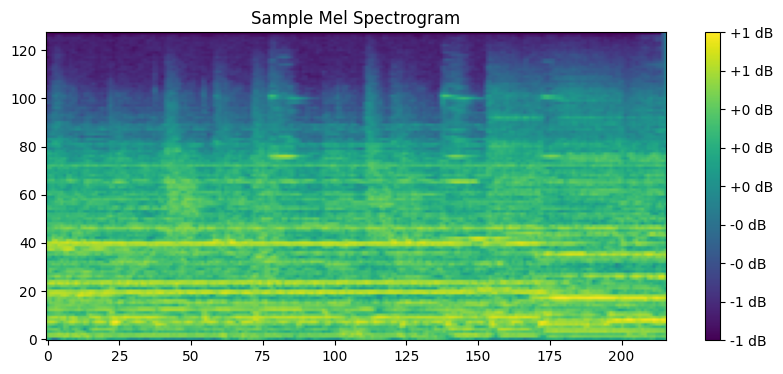

In [13]:
# Save as numpy files
np.save(os.path.join(SAVE_DIR, 'train_specs.npy'), x_train)
np.save(os.path.join(SAVE_DIR, 'val_specs.npy'), x_val)
np.save(os.path.join(SAVE_DIR, 'test_specs.npy'), x_test)

# Visualize a random sample to check
plt.figure(figsize=(10, 4))
plt.imshow(x_train[0, 0], aspect='auto', origin='lower')
plt.title("Sample Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

In [14]:
# Test rapide pour calculer les dimensions
import librosa
test_audio = np.random.randn(5 * 22050)  # 5 secondes de test
test_spec = create_mel_spectrogram(test_audio, 22050, 128)
print(f"Dimensions du spectrogramme: {test_spec.shape}")
print(f"Format final avec channel: [1, {test_spec.shape[0]}, {test_spec.shape[1]}]")

Dimensions du spectrogramme: (128, 216)
Format final avec channel: [1, 128, 216]


# 🔧 Configuration du Preprocessing

Vous pouvez facilement ajuster les paramètres :

## Limitation de dossiers
- **`MAX_FOLDERS = 50`** : Traite seulement les 50 premiers dossiers (rapide pour tests)
- **`MAX_FOLDERS = None`** : Traite tous les dossiers (preprocessing complet)

## Autres paramètres
- **`DURATION_SEC = 5`** : Durée en secondes par segment audio
- **`SAMPLE_RATE = 22050`** : Fréquence d'échantillonnage 
- **`N_MELS = 128`** : Nombre de bins mel dans le spectrogramme

### Exemples d'usage :
- **Test rapide** : `MAX_FOLDERS = 10` (quelques minutes)
- **Dataset moyen** : `MAX_FOLDERS = 50` (recommandé)
- **Dataset complet** : `MAX_FOLDERS = None` (plusieurs heures)